## Customer Segmentation 

<b>Problem Statement - </b> Most e-commerce businesses lose their potential growth by not being able to                       identify their target customer and their preferences as there are an unimaginable variety of                  people and personalities present in the world. This results in a waste of advertising and                      marketing funds and time.
        Using this project, we will develop a model that predicts what a new client will buy in the coming year and how much they will spend after their first purchase.  

### Data Set Description

- This is a transnational data collection that includes all transactions made by a UK-based and registered non-store internet retailer between December 1, 2010 and December 9, 2011. The company specializes on selling one-of-a-kind presents for any occasion. Wholesalers make up a large portion of the company's clientele.

![alt text](csv_file_snap.png " DataFile Snap" )

###  Importing required libraries and packages

In [282]:
from IPython.display import display, HTML
import pandas as pd
import sqlite3
import os
import seaborn as sns
# import required sklearn functions and APIs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Util functions for DB Operations

In [283]:
def create_connection(db_file, delete_db=False):
    
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Exception as e:
        print(e)

    return conn

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

## Database Tables Description

### Entity Relationship Diagram 

![alt text](ERD.png " DataFile Snap" )

### Table Creation Script for Normalized Db

In [284]:
# split the dataset into three tables as below
conn = create_connection('normalized.db',delete_db=True)
cur = conn.cursor()

cur.executescript("""

CREATE TABLE Country (CountryID INTEGER NOT NULL PRIMARY KEY,
                      Country TEXT NOT NULL);

CREATE TABLE Customer (CustomerID INTEGER NOT NULL PRIMARY KEY,
                       Customer INTEGER NOT NULL);


CREATE TABLE Invoice (InvoiceID INTEGER NOT NULL PRIMARY KEY,
                      InvoiceNo INTEGER NOT NULL,
                      InvoiceDate TEXT NOT NULL);

CREATE TABLE ProductInfo (ProductID INTEGER NOT NULL PRIMARY KEY,
                         ProductName TEXT NOT NULL,
                         StockCode INTEGER NOT NULL,
                         UnitPrice INTEGER NOT NULL);


CREATE TABLE Orders (OrderId INTEGER NOT NULL PRIMARY KEY,
                     CustomerID INTEGER NOT NULL,
                     CountryID INTEGER NOT NULL,
                     InvoiceID INTEGER NOT NULL,
                     ProductID INTEGER NOT NULL,
                     Quantity INTEGER NOT NULL,
                     FOREIGN KEY(ProductID) REFERENCES ProductInfo(ProductID),
                     FOREIGN KEY(CountryID) REFERENCES Country(CountryID),
                     FOREIGN KEY(InvoiceID) REFERENCES Invoice(InvoiceID),
                     FOREIGN KEY(CustomerID) REFERENCES Customer(CustomerID)
                     );
""")
conn.commit()

### Data Cleaning and Storing into Tables
- Removed rows which contains Country as <b>'Unspecified'</b>
- Removed rows which contains Product as <b>'missing,??,?,'</b>
- Removed rows for which Invoice Date was not in <b>%Y-%m-%d %H:%M:%S</b> format

In [285]:
# store all table values
# file should be in the same directory in order 
with open('csvfile.csv','r') as f:
    next(f)
    products =[]
    invoice_nos =[]
    invoice_dates =[]
    countries =[]
    customers =[]
    for i in f:
        i = i.split(',')
        country = i[-1].rstrip()
        product = i[2]
        stock_code = i[1]
        try:
            if country not in ('','Unspecified'):
                countries.append(country)

                if product not in ('','??missing',' ','?') and stock_code not in ('',' '):
                    unit_price = float(i[5])
                    row_for_product =  (stock_code, product, unit_price)
                    products.append(row_for_product)
                invoice_no =int(i[0])
                invoice_date = i[4]
                invoice_nos.append(invoice_no)
                if invoice_date.count('-')>=2:
                    invoice_dates.append(invoice_date)
                customer_id = int(float(i[6]))
                customers.append((customer_id,))
        except Exception as e:
            pass

        
countries =[(i,) for i in sorted((set(countries)))]

customers = list(set(customers))


invoice_dates = list(set(invoice_dates))
invoice_nos = list(set(invoice_nos))

invoices = list(zip(invoice_nos,invoice_dates))

cur.executemany("INSERT INTO Country ('Country')VALUES (?);",countries)
conn.commit()

cur.executemany("INSERT INTO ProductInfo('StockCode','ProductName','UnitPrice')VALUES (?,?,?);",products)
conn.commit()

cur.executemany("INSERT INTO Invoice (InvoiceNo,InvoiceDate) VALUES (?,?);",invoices)
conn.commit()

cur.executemany("INSERT INTO Customer(Customer) VALUES (?);",customers)
conn.commit()

### Function to map values with Primary key 

In [286]:
# to get fetchall as dict instead of tuple
def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d


def create_dictionary(db_file,table_name,map_from,map_to):
    conn = create_connection(db_file)
    conn.row_factory = dict_factory
    results = execute_sql_statement(f"SELECT * FROM {table_name};",conn)
    return_dict = {}
    for i in results:
        value= i.get(map_to)
        key = i.get(map_from)
            
        return_dict[key] = value
        
    return return_dict

### Mapped dictionary  for the Country Table

In [287]:
countries_dict = create_dictionary('normalized.db','Country','Country','CountryID')
countries_dict

{'Australia': 1,
 'Austria': 2,
 'Bahrain': 3,
 'Belgium': 4,
 'Brazil': 5,
 'Canada': 6,
 'Channel Islands': 7,
 'Cyprus': 8,
 'Czech Republic': 9,
 'Denmark': 10,
 'EIRE': 11,
 'European Community': 12,
 'Finland': 13,
 'France': 14,
 'Germany': 15,
 'Greece': 16,
 'Hong Kong': 17,
 'Iceland': 18,
 'Israel': 19,
 'Italy': 20,
 'Japan': 21,
 'Lebanon': 22,
 'Lithuania': 23,
 'Malta': 24,
 'Netherlands': 25,
 'Norway': 26,
 'Poland': 27,
 'Portugal': 28,
 'RSA': 29,
 'Saudi Arabia': 30,
 'Singapore': 31,
 'Spain': 32,
 'Sweden': 33,
 'Switzerland': 34,
 'USA': 35,
 'United Arab Emirates': 36,
 'United Kingdom': 37}

### Mapped dictionary  for the Product Table

In [288]:
product_dict = create_dictionary('normalized.db','ProductInfo','ProductName','ProductID')
product_dict

{'WHITE HANGING HEART T-LIGHT HOLDER': 534560,
 'WHITE METAL LANTERN': 470331,
 'CREAM CUPID HEARTS COAT HANGER': 521032,
 'KNITTED UNION FLAG HOT WATER BOTTLE': 535947,
 'RED WOOLLY HOTTIE WHITE HEART.': 535850,
 'SET 7 BABUSHKA NESTING BOXES': 534351,
 'GLASS STAR FROSTED T-LIGHT HOLDER': 529556,
 'HAND WARMER UNION JACK': 535551,
 'HAND WARMER RED POLKA DOT': 5203,
 'ASSORTED COLOUR BIRD ORNAMENT': 536202,
 "POPPY'S PLAYHOUSE BEDROOM ": 535332,
 "POPPY'S PLAYHOUSE KITCHEN": 535333,
 'FELTCRAFT PRINCESS CHARLOTTE DOLL': 535334,
 'IVORY KNITTED MUG COSY ': 534288,
 'BOX OF 6 ASSORTED COLOUR TEASPOONS': 526475,
 'BOX OF VINTAGE JIGSAW BLOCKS ': 528639,
 'BOX OF VINTAGE ALPHABET BLOCKS': 536114,
 'HOME BUILDING BLOCK WORD': 535689,
 'LOVE BUILDING BLOCK WORD': 536068,
 'RECIPE BOX WITH METAL HEART': 21492,
 'DOORMAT NEW ENGLAND': 536061,
 'JAM MAKING SET WITH JARS': 535798,
 'RED COAT RACK PARIS FASHION': 523585,
 'YELLOW COAT RACK PARIS FASHION': 501690,
 'BLUE COAT RACK PARIS FASHION'

### Mapped dictionary  for the Customer Table

In [289]:
customer_dict = create_dictionary('normalized.db','Customer','Customer','CustomerID')
customer_dict

{13142: 1,
 16260: 2,
 14045: 3,
 17163: 4,
 14948: 5,
 16934: 6,
 12733: 7,
 18066: 8,
 17837: 9,
 13636: 10,
 15622: 11,
 14539: 12,
 16525: 13,
 17428: 14,
 13227: 15,
 15213: 16,
 16116: 17,
 18102: 18,
 13901: 19,
 17019: 20,
 14804: 21,
 16790: 22,
 12589: 23,
 17693: 24,
 13492: 25,
 15478: 26,
 13263: 27,
 17284: 28,
 15069: 29,
 12854: 30,
 17958: 31,
 15743: 32,
 14660: 33,
 12445: 34,
 14431: 35,
 17549: 36,
 15334: 37,
 17320: 38,
 18223: 39,
 14022: 40,
 16008: 41,
 12710: 42,
 14696: 43,
 15599: 44,
 13384: 45,
 14287: 46,
 17405: 47,
 17176: 48,
 14961: 49,
 16093: 50,
 18079: 51,
 13878: 52,
 15864: 53,
 13649: 54,
 16767: 55,
 12566: 56,
 14552: 57,
 17670: 58,
 13240: 59,
 16358: 60,
 14143: 61,
 15046: 62,
 12831: 63,
 14817: 64,
 17935: 65,
 12602: 66,
 15720: 67,
 13505: 68,
 16623: 69,
 14408: 70,
 16394: 71,
 17526: 72,
 15311: 73,
 17297: 74,
 18200: 75,
 13999: 76,
 15985: 77,
 14673: 78,
 12458: 79,
 17791: 80,
 15576: 81,
 17562: 82,
 15347: 83,
 16479: 84,
 

### Mapped dictionary  for the Invoice Table

In [290]:
invoice_dict = create_dictionary('normalized.db','Invoice','InvoiceNo','InvoiceID')
invoice_dict

{536365: 1,
 536366: 2,
 536367: 3,
 536368: 4,
 536369: 5,
 536370: 6,
 536371: 7,
 536372: 8,
 536373: 9,
 536374: 10,
 536375: 11,
 536376: 12,
 536377: 13,
 536378: 14,
 536380: 15,
 536381: 16,
 536382: 17,
 536384: 18,
 536385: 19,
 536386: 20,
 536387: 21,
 536388: 22,
 536389: 23,
 536390: 24,
 536392: 25,
 536393: 26,
 536394: 27,
 536395: 28,
 536396: 29,
 536397: 30,
 536398: 31,
 536399: 32,
 536400: 33,
 536401: 34,
 536402: 35,
 536403: 36,
 536404: 37,
 536405: 38,
 536406: 39,
 536407: 40,
 536408: 41,
 536409: 42,
 536412: 43,
 536414: 44,
 536415: 45,
 536416: 46,
 536420: 47,
 536423: 48,
 536425: 49,
 536437: 50,
 536446: 51,
 536460: 52,
 536463: 53,
 536464: 54,
 536466: 55,
 536477: 56,
 536488: 57,
 536500: 58,
 536502: 59,
 536508: 60,
 536514: 61,
 536520: 62,
 536521: 63,
 536522: 64,
 536523: 65,
 536524: 66,
 536525: 67,
 536526: 68,
 536527: 69,
 536528: 70,
 536529: 71,
 536530: 72,
 536531: 73,
 536532: 74,
 536533: 75,
 536534: 76,
 536535: 77,
 536536:

### Data Insertion for Order table with Foreign Keys

In [291]:
with open('csvfile.csv','r') as f:
    next(f)
    all_order_data =[]
    products =[]
    stocks = []
    countries =[]
    for i in f:
        i = i.split(',')
        try:
            invoice_no =int(i[0])
            quantity = int(i[3])
            customer_id = int(float(i[6]))
            prooduct_name = i[2]
            country_name =i[-1]
            product_id = product_dict.get(prooduct_name)
            country_id = countries_dict.get(country_name.rstrip())
            invoice_id = invoice_dict.get(invoice_no)
            customer_id = customer_dict.get(customer_id)
            if all([product_id,country_id,invoice_id,customer_id]):
                row_for_insertation = (invoice_id,product_id,quantity,customer_id,country_id,)
                all_order_data.append(row_for_insertation)
        except Exception as e:
            pass 

all_order_data = list(set(all_order_data))
cur.executemany("""INSERT INTO Orders ('InvoiceID','ProductID','Quantity',
                'CustomerID','CountryID')
                VALUES (?,?,?,?,?);""",all_order_data)
conn.commit()

## Exploratory Data Analysis

#### Get the spending of all countires using Pie Chart

<AxesSubplot:title={'center':'Spending of all countires'}, ylabel='Total'>

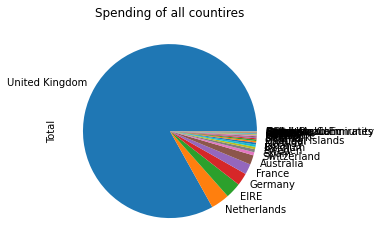

In [292]:
# get the spending of all countires
sql_statement = """ Select Country,
                               round(sum(Productinfo.UnitPrice*orders.Quantity),2) as Total
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        INNER JOIN Country USING(CountryID)
                        Group by Country
                        Order by Total Desc;"""
df1 = pd.read_sql_query(sql_statement, conn)
df1.set_index('Country', inplace=True)
df1.plot.pie(y='Total', legend=False,title="Spending of all countires")

#### Ploting the spending of top 10 Customers

<AxesSubplot:title={'center':'Spending by top 10 Customers'}, ylabel='Total'>

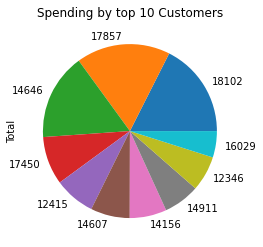

In [293]:
# get the spending by  customers
sql_statement = """ Select Customer,
                               round(sum(Productinfo.UnitPrice*orders.Quantity),2) as Total
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        INNER JOIN Customer USING(CustomerID)
                        Group by Customer
                        Order by Total Desc
                        limit 10;"""
df2 = pd.read_sql_query(sql_statement, conn)
df2.set_index('Customer', inplace=True)
df2.plot.pie(y='Total', legend=False,title="Spending by top 10 Customers")

#### Top 10 most order products

<AxesSubplot:title={'center':'Top 10 Most Ordered Product'}, ylabel='Quantity'>

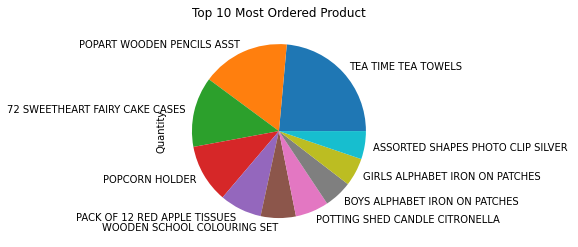

In [294]:
# get the top 10 prducts order
sql_statement = """ Select ProductName,Quantity
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        Group by ProductID
                        Order by Quantity Desc
                        limit 10;"""
df3 = pd.read_sql_query(sql_statement, conn)
df3.set_index('ProductName',inplace=True)
df3.plot.pie(y='Quantity',legend=False,title="Top 10 Most Ordered Product")

####                         Top 10 Products sold in UK

Text(0.5, 1.0, 'Top 10 Products sold in UK')

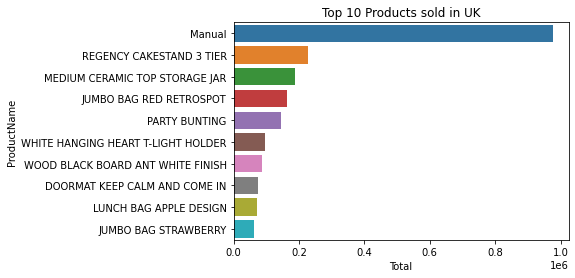

In [295]:
sql_statement = """ Select ProductName,
                               round(sum(Productinfo.UnitPrice*orders.Quantity),2) as Total
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        INNER JOIN Country USING(CountryID)
                        WHERE Country='United Kingdom'
                        Group by ProductID
                        Order by Total Desc
                        limit 10;"""
df4 = pd.read_sql_query(sql_statement, conn)
sns.barplot(x='Total',y='ProductName',data=df4).set_title("Top 10 Products sold in UK")

#### Top 10 Products sold outside UK

Text(0.5, 1.0, 'Top 10 Products sold outside UK')

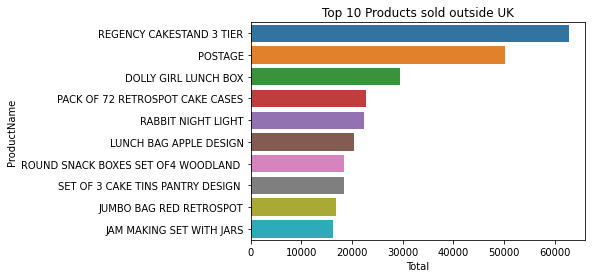

In [296]:
sql_statement = """ Select ProductName,
                               round(sum(Productinfo.UnitPrice*orders.Quantity),2) as Total
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        INNER JOIN Country USING(CountryID)
                        WHERE Country !='United Kingdom'
                        Group by ProductID
                        Order by Total Desc
                        limit 10;"""
df5 = pd.read_sql_query(sql_statement, conn)
sns.barplot(x='Total',y='ProductName',data=df5).set_title("Top 10 Products sold outside UK")

#### Top 10 Customers in terms of sales in UK

Text(0.5, 1.0, 'Top 10 Customers in terms of sales in UK')

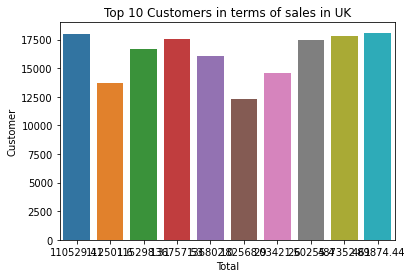

In [297]:
# top 10 customers in terms of sales in UK
sql_statement = """ Select Customer,
                        round(sum(Productinfo.UnitPrice*orders.Quantity),2) as Total
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        INNER JOIN Customer USING(CustomerID)
                        WHERE CountryID IN(
                        Select CountryID
                           From Country 
                           WHERE Country='United Kingdom'
                        )
                        Group by CustomerID
                        Order by Total Desc
                        limit 10
                        """
df6 = pd.read_sql_query(sql_statement, conn)
sns.barplot(x='Total',y='Customer',data=df6).set_title("Top 10 Customers in terms of sales in UK")

#### Top 10 Customers in terms of sales outside UK

Text(0.5, 1.0, 'Top 10 Customers in terms of sales outside UK')

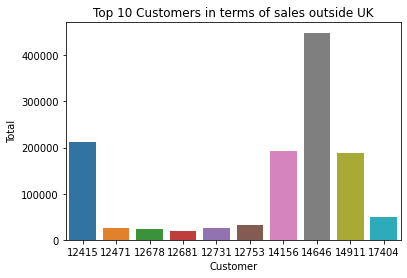

In [298]:
# top 10 customers in terms of sales outside UK
sql_statement = """ Select Customer,
                        round(sum(Productinfo.UnitPrice*orders.Quantity),2) as Total
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        INNER JOIN Customer USING(CustomerID)
                        WHERE CountryID IN(
                        Select CountryID
                           From Country 
                           WHERE Country !='United Kingdom'
                        )
                        Group by CustomerID
                        Order by Total Desc
                        limit 10
                        """
df7 = pd.read_sql_query(sql_statement, conn)
sns.barplot(x='Customer',y='Total',data=df7).set_title("Top 10 Customers in terms of sales outside UK")

Text(0.5, 1.0, 'Top 10 frequent Customers in UK')

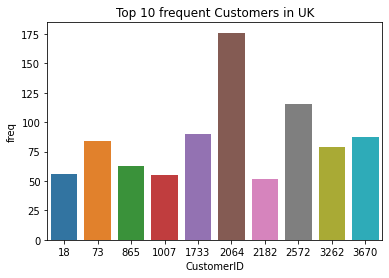

In [299]:
# top 10  customers in terms of frequency(how frequent customer shops) in UK
sql_statement = """ Select CustomerID,count(distinct(InvoiceID)) as freq
                        From Orders
                        WHERE CountryID IN(
                        Select CountryID From Country
                        Where Country='United Kingdom'
                        )
                        Group by CustomerID
                        Order by freq Desc
                        limit 10
                        """
df8 = pd.read_sql_query(sql_statement, conn)
sns.barplot(x='CustomerID',y='freq',data=df8).set_title("Top 10 frequent Customers in UK")

Text(0.5, 1.0, 'Top 10 frequent Customers outside UK')

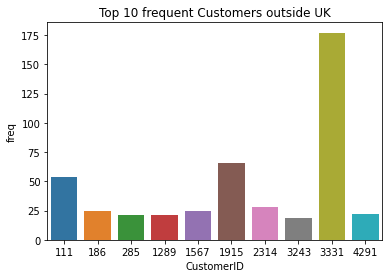

In [300]:
# top 10  customers in terms of frequency(how frequent customer shops) outside UK
sql_statement = """ Select CustomerID,count(distinct(InvoiceID)) as freq
                        From Orders
                        WHERE CountryID IN(
                        Select CountryID From Country
                        Where Country !='United Kingdom'
                        )
                        Group by CustomerID
                        Order by freq Desc
                        limit 10
                        """
df9 = pd.read_sql_query(sql_statement, conn)
sns.barplot(x='CustomerID',y='freq',data=df9).set_title("Top 10 frequent Customers outside UK")

## RFM Analysis

RFM stands for recency, frequency, and monetary. This segmentation enables marketers to target specific groups of customers with communications that are far more relevant to their unique behaviors, resulting in significantly higher response rates, as well as enhanced loyalty and customer lifetime value. RFM segmentation, like other segmentation approaches, is an effective way to identify groups of customers who should be treated differently.
<br>
<br>
- <b> Recency - </b>  How long has it been since a customer engaged in an activity or made a purchase with the brand? The more recently a customer has interacted or transacted with a brand, the more likely that customer will be responsive to brand messages.
<br>
<br>
- <b> Frequency - </b> During a given time period, how many times has a client transacted or interacted with the brand? Customers who participate in activities on a regular basis are clearly more involved and loyal than those who do so infrequently.
<br>
<br>
- <b>Monetary -</b> This indicates how much money a consumer has spent with the company over a specific period of time. Customers who spend a lot of money should be handled differently than customers who spend a little.
<br>

### Fetching Recency, Frequency and Monetary for Customers

In [301]:
sql_statement = """Select CustomerID,InvoiceDate,count(distinct(InvoiceID)) as freq
                        From Orders
                        INNER JOIN Invoice USING (InvoiceID)
                        Group by CustomerID
                        """
df10 = pd.read_sql_query(sql_statement, conn)
df10['InvoiceDate'] = pd.to_datetime(df10['InvoiceDate'],format='%Y-%m-%d %H:%M:%S',errors='coerce')
df10.dropna(inplace=True)
df10['MaxDate'] = df10['InvoiceDate'].max()
df10['recency'] = (df10['MaxDate'] - df10['InvoiceDate']).dt.days + 1
df10

,CustomerID,InvoiceDate,freq,MaxDate,recency
0,2,2011-09-02 13:00:00,1,2011-12-09 12:21:00,98
1,3,2011-10-23 10:38:00,4,2011-12-09 12:21:00,48
2,4,2011-02-25 13:53:00,2,2011-12-09 12:21:00,287
3,5,2011-11-04 11:41:00,6,2011-12-09 12:21:00,36
4,6,2011-07-05 09:34:00,2,2011-12-09 12:21:00,158
...,...,...,...,...,...
4173,4329,2011-06-09 12:04:00,1,2011-12-09 12:21:00,184
4174,4330,2011-11-01 14:03:00,3,2011-12-09 12:21:00,38
4175,4331,2010-12-22 14:28:00,3,2011-12-09 12:21:00,352
4176,4332,2011-11-16 13:33:00,2,2011-12-09 12:21:00,23


In [302]:
sql_statement = """ Select CustomerID,
                        round(sum(Productinfo.UnitPrice*orders.Quantity),2) as Total
                        From Orders
                        INNER JOIN ProductInfo USING(ProductID)
                        INNER JOIN Customer USING(CustomerID)
                        Group by CustomerID
                        """
df7 = pd.read_sql_query(sql_statement, conn)
df10['monetary'] = df7['Total']

In [303]:
df10.drop(['MaxDate','InvoiceDate'], axis=1,inplace=True, errors='ignore')
df10

,CustomerID,freq,recency,monetary
0,2,1,98,1350.27
1,3,4,48,3070.27
2,4,2,287,309.90
3,5,6,36,1865.22
4,6,2,158,1085.99
...,...,...,...,...
4173,4329,1,184,130.09
4174,4330,3,38,839.35
4175,4331,3,352,4132.99
4176,4332,2,23,974.38


## K-Mean Clustering

For this project, we have used a popular unsupervised learning technique called K-Means clustering. This algorithm is very useful in our case as it takes unlabelled customer data and assigns each data point to clusters. Using K-means clustering we will group the customers into three unique groups that are distinct from each other. That means each cluster will consist of features that are different from other clusters. K-Means clustering is a commonly used technique for data analysis to help companies with customer segmentation

### Pefroming EDA on Fetched RFM Dataset

In [304]:
df10.head()

,CustomerID,freq,recency,monetary
0,2,1,98,1350.27
1,3,4,48,3070.27
2,4,2,287,309.90
3,5,6,36,1865.22
4,6,2,158,1085.99


In [305]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4178 entries, 0 to 4177
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4178 non-null   int64  
 1   freq        4178 non-null   int64  
 2   recency     4178 non-null   int64  
 3   monetary    4178 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 163.2 KB


In [306]:
df10.dtypes

CustomerID      int64
freq            int64
recency         int64
monetary      float64
dtype: object

In [307]:
df10.describe()

,CustomerID,freq,recency,monetary
count,4178.000000,4178.000000,4178.000000,4178.000000
mean,2166.339636,3.993059,159.878889,3157.931367
std,1252.054327,7.045439,110.698668,16386.287136
min,2.000000,1.000000,1.000000,3.750000
25%,1081.250000,1.000000,58.000000,413.070000
50%,2168.500000,2.000000,149.000000,932.570000
75%,3255.750000,4.000000,253.000000,2329.792500
max,4333.000000,177.000000,374.000000,489874.440000


#### Checking for Outliers

<AxesSubplot:xlabel='recency'>

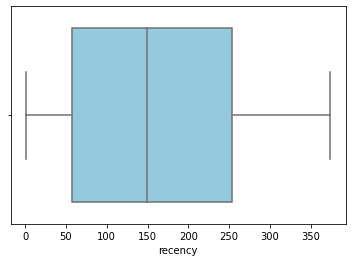

In [308]:
sns.boxplot(x = df10['recency'], color='skyblue')

In [309]:
df10

,CustomerID,freq,recency,monetary
0,2,1,98,1350.27
1,3,4,48,3070.27
2,4,2,287,309.90
3,5,6,36,1865.22
4,6,2,158,1085.99
...,...,...,...,...
4173,4329,1,184,130.09
4174,4330,3,38,839.35
4175,4331,3,352,4132.99
4176,4332,2,23,974.38


<AxesSubplot:xlabel='monetary'>

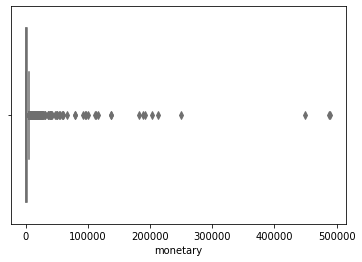

In [310]:
sns.boxplot(x = df10['monetary'], color='skyblue')

#### Removing Outliers from the data

In [311]:
df10.drop('CustomerID',axis=1,inplace=True,errors='ignore')
# Remove Outliers

def remove_outliers(df,column_name):
    Q1 = getattr(df,column_name).quantile(0.05)
    Q3 = getattr(df,column_name).quantile(0.95)
    IQR = Q3 - Q1
    df = df[ (getattr(df,column_name) >= Q1 - 1.5*IQR) & (getattr(df,column_name) <= Q3 + 1.5*IQR)]

remove_outliers(df10,'freq')
remove_outliers(df10,'recency')
remove_outliers(df10,'monetary')

#### Standardize features by removing the mean and scaling to unit variance

In [312]:
# scaling the variables and store it in different df
standard_scaler = StandardScaler()
df10 = standard_scaler.fit_transform(df10)
# converting it into dataframe
df10  = pd.DataFrame(df10 )
df10.columns = ['frequency','recency','monetary']
df10 

,frequency,recency,monetary
0,-0.424873,-0.559052,-0.110329
1,0.000985,-1.010783,-0.005350
2,-0.282920,1.148490,-0.173827
3,0.284891,-1.119198,-0.078899
4,-0.282920,-0.016975,-0.126459
...,...,...,...
4173,-0.424873,0.217925,-0.184801
4174,-0.140967,-1.101129,-0.141512
4175,-0.140967,1.735740,0.059512
4176,-0.282920,-1.236648,-0.133271


### Performing Clustering Using KMeans

In [313]:
# Kmeans with K=5

model_clus5 = KMeans(n_clusters = 3)
model_clus5.fit(df_cluster_norm)

KMeans(n_clusters=3)

In [314]:
model_clus5.labels_

array([2, 2, 1, ..., 1, 2, 1], dtype=int32)

In [315]:
df_cluster_norm['clusters'] = model_clus5.labels_

## Results and Conclusion

We categorized the customer data into 3 clusters and checked their RFM (Recency, Frequency, Monetary) values.
The graphs below show the distribution of RFM with respect to clusters:

Text(0.5, 1.0, 'Frequency VS Clusters')

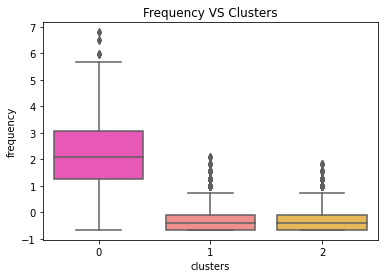

In [316]:
sns.boxplot(y=df_cluster_norm['frequency'], 
            x=df_cluster_norm['clusters'], palette='spring').set_title("Frequency VS Clusters")

Text(0.5, 1.0, 'Recency VS Clusters')

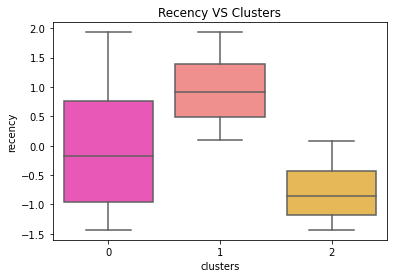

In [317]:
sns.boxplot(y=df_cluster_norm['recency'], 
            x=df_cluster_norm['clusters'], palette='spring').set_title("Recency VS Clusters")

Text(0.5, 1.0, 'Monetary VS Clusters')

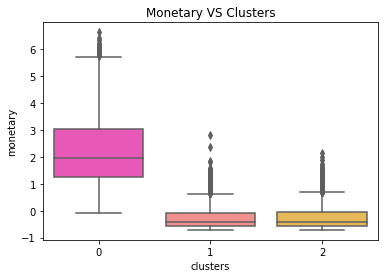

In [318]:
sns.boxplot(y=df_cluster_norm['monetary'], 
            x=df_cluster_norm['clusters'], palette='spring').set_title("Monetary VS Clusters")